In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from pathlib import Path
import re
import random
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading the BF data

In [3]:
bf_path = '/content/drive/MyDrive/ALL_CLEAN_DEIDEN_NAME AND ECMO DATA(Sheet1) (1) (version 2).csv'
cols = ['ID', 'age_days', 'weight', 'study_height', 'Diagnosis']
df = pd.read_csv(bf_path, usecols=cols)

for col in ['weight', 'study_height', 'age_days']:
    s = pd.to_numeric(df[col], errors='coerce')
    mx = s.max(skipna=True)
    if pd.notna(mx) and mx != 0:
        df[col] = s / mx
    else:
        df[col] = s
print(df.head())

   ID  age_days            Diagnosis    weight  study_height
0   1  0.018213       Cardiac Arrest  0.042214      0.344538
1   2  0.072852       Cardiac Arrest  0.070000      0.431373
2   3  0.793776               Sepsis  0.403571      0.896359
3   4  0.000287  Respiratory Failure  0.022786      0.268908
4   5  0.000287  Respiratory Failure  0.023571      0.285714


In [4]:
diag_clean = (
    df['Diagnosis']
      .astype('string')
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)
      .fillna('Unknown')
)

codes, uniques = pd.factorize(diag_clean, sort=True)
df['Diagnosis'] = codes.astype('int64')
diagnosis_mapping = {cat: int(i) for i, cat in enumerate(uniques)}
print("Diagnosis mapping (category -> code):", diagnosis_mapping)
# Peek
print(df.head())

Diagnosis mapping (category -> code): {'Cardiac Arrest': 0, 'Cardiogenic Shock': 1, 'Respiratory Failure': 2, 'Respiratory Failure, Cardiac Arrest': 3, 'Sepsis': 4, 'Septic shock': 5}
   ID  age_days  Diagnosis    weight  study_height
0   1  0.018213          0  0.042214      0.344538
1   2  0.072852          0  0.070000      0.431373
2   3  0.793776          4  0.403571      0.896359
3   4  0.000287          2  0.022786      0.268908
4   5  0.000287          2  0.023571      0.285714


In [5]:
df.shape

(73, 5)

### No normalization!

In [6]:
from pathlib import Path
import re, random, math, os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Config
# =========================
SPLIT_DIR = r"/content/drive/MyDrive/CD/patient_data_clean_nozero_181920212223_1800"
POS_PATIENTS = {1, 2, 16, 19, 21, 22, 25, 37, 39, 43, 44, 47, 50, 56, 58, 62, 65, 66, 73, 78}

BATCH_SIZE       = 3
EPOCHS           = 100
LR               = 1e-4
SEED             = 1

# =========================
# Repro
# =========================
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
for g in tf.config.list_physical_devices('GPU'):
    try: tf.config.experimental.set_memory_growth(g, True)
    except Exception: pass

# =========================
# Helpers
# =========================
PATIENT_NUM_RX = re.compile(r'^ID(\d+)')  # e.g., "ID76-2_..." -> 76

def patient_num_from_path(pathlike):
    stem = Path(pathlike).stem
    m = PATIENT_NUM_RX.match(stem)
    return int(m.group(1)) if m else None

def label_for_file(p: Path) -> int:
    pnum = patient_num_from_path(p)
    return 1 if (pnum is not None and pnum in POS_PATIENTS) else 0

# =========================
# Load pre-existing 4-feature DataFrame: df (must be in memory)
# Must contain column 'ID' + exactly 4 feature columns.
# =========================
feats_df = df.copy()  # <-- uses your in-memory DataFrame
if "ID" not in feats_df.columns:
    raise RuntimeError("Your features DataFrame must contain column 'ID'.")

FEAT_COLS = [c for c in feats_df.columns if c != "ID"]
#if len(FEAT_COLS) != 4:
#    raise RuntimeError(f"Expected exactly 4 feature columns besides 'ID', found {len(FEAT_COLS)}: {FEAT_COLS}")

# Clean and index by ID; drop rows with missing any of the 4 features
feats_df["ID"] = pd.to_numeric(feats_df["ID"], errors="coerce").astype("Int64")
feats_df = feats_df.dropna(subset=["ID"] + FEAT_COLS).copy()
feats_df["ID"] = feats_df["ID"].astype(int)

ID_TO_FEAT = {
    int(row["ID"]): row[FEAT_COLS].astype("float32").to_numpy()
    for _, row in feats_df.iterrows()
}
FEAT_DIM = len(FEAT_COLS)
print('FEAT_DIM =', FEAT_DIM)

# =========================
# List EEG files ONLY to define splits by patient ID (no EEG is loaded)
# =========================
split_dir = Path(SPLIT_DIR)
all_csvs = sorted(split_dir.glob("*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSV found in {SPLIT_DIR}")

# Map: id -> list of files for that patient
id_to_files = {}
for f in all_csvs:
    pid = patient_num_from_path(f)
    if pid is None:
        continue
    id_to_files.setdefault(pid, []).append(f)

all_ids = sorted(id_to_files.keys())

# Use only IDs that have the required 4 features
valid_ids = [pid for pid in all_ids if pid in ID_TO_FEAT]
if not valid_ids:
    raise RuntimeError("No overlapping patient IDs between files and the 4-feature table.")
if len(valid_ids) < len(all_ids):
    print(f"Dropping {len(all_ids)-len(valid_ids)} patient IDs without 4-feature rows.")

labels_all = np.array([1 if pid in POS_PATIENTS else 0 for pid in valid_ids], dtype=int)

print("Total valid IDs:", len(valid_ids),
      "| Pos IDs:", labels_all.sum(),
      "| Neg IDs:", (1 - labels_all).sum())

# =========================
# Data Sequence (tab-only)
# Each file becomes one sample with that patient's 4 features.
# =========================
class TabSequence(keras.utils.Sequence):
    def __init__(self, files, batch_size=BATCH_SIZE, shuffle=True):
        super().__init__()
        # Keep only files whose patient ID has 4 features
        self.files = [f for f in files if patient_num_from_path(f) in ID_TO_FEAT]
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.files) / self.batch_size)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        idxs = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_files = [self.files[i] for i in idxs]
        B = len(batch_files)

        X_tab = np.empty((B, FEAT_DIM), dtype=np.float32)
        y     = np.empty((B,), dtype=np.int32)

        for i, f in enumerate(batch_files):
            pid = patient_num_from_path(f)
            X_tab[i] = ID_TO_FEAT[pid]      # (4,)
            y[i] = label_for_file(f)

        return {"tab_input": X_tab}, y

# =========================
# Tab-only Model: 4 -> 8 -> 8 -> 1
# =========================
def build_model(tab_dim=FEAT_DIM, lr=LR, dropout=0.2):
    tab_in = keras.Input(shape=(tab_dim,), name="tab_input")
    t = layers.Dense(8, activation="relu")(tab_in)
    t = layers.Dense(8, activation="relu")(t)
    t = layers.Dropout(dropout)(t)
    out = layers.Dense(1, activation="sigmoid")(t)

    model = keras.Model(inputs=tab_in, outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"),
                 keras.metrics.AUC(name="auc")],
    )
    return model

# =========================
# 10-fold Cross-Validation by patient ID (stratified)
# =========================
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

fold_aucs = []
for fold_idx, (train_index, test_index) in enumerate(skf.split(valid_ids, labels_all), start=1):
    ids_train_full = [valid_ids[i] for i in train_index]
    ids_test       = [valid_ids[i] for i in test_index]

    # small validation split from training IDs (stratified, by ID)
    train_labels_full = np.array([1 if pid in POS_PATIENTS else 0 for pid in ids_train_full], dtype=int)
    ids_tr, ids_val = train_test_split(
        ids_train_full, test_size=0.10, random_state=SEED,
        stratify=train_labels_full
    )

    # Build file lists for this fold
    train_files = [f for pid in ids_tr  for f in id_to_files[pid]]
    val_files   = [f for pid in ids_val for f in id_to_files[pid]]
    test_files  = [f for pid in ids_test for f in id_to_files[pid]]

    print(f"\n--- Fold {fold_idx}/10 ---")
    def split_summary_by_ids(name, ids, files):
        ys = np.array([label_for_file(f) for f in files], dtype=int)
        print(f"{name:>6} | ids: {len(ids):4d} | files: {len(files):4d} | pos: {(ys==1).sum():4d} | neg: {(ys==0).sum():4d}")
    split_summary_by_ids("train", ids_tr,  train_files)
    split_summary_by_ids("val",   ids_val, val_files)
    split_summary_by_ids("test",  ids_test, test_files)

    # Generators
    train_gen = TabSequence(train_files, batch_size=BATCH_SIZE, shuffle=True)
    val_gen   = TabSequence(val_files,   batch_size=BATCH_SIZE, shuffle=False)

    # Model + training
    model = build_model()
    best_path = f"best_tab_only_fold{fold_idx}.h5"
    ckpt = keras.callbacks.ModelCheckpoint(
        best_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[ckpt],
        verbose=1,
    )

    # Evaluate on this fold's test set
    best_model = keras.models.load_model(best_path)

    test_files2 = [f for f in test_files if patient_num_from_path(f) in ID_TO_FEAT]
    X_tab_test = np.empty((len(test_files2), FEAT_DIM), dtype=np.float32)
    for i, f in enumerate(test_files2):
        X_tab_test[i] = ID_TO_FEAT[patient_num_from_path(f)]
    y_true = np.array([label_for_file(f) for f in test_files2], dtype=int)

    probs1 = best_model.predict({"tab_input": X_tab_test}, verbose=0).ravel().astype(float)
    try:
        auc = roc_auc_score(y_true, probs1)
    except ValueError:
        auc = float('nan')

    fold_aucs.append(float(auc))
    print(f"Fold {fold_idx} AUC: {auc:.4f}")

# =========================
# Results across folds
# =========================
print("\nAUCs per fold:", fold_aucs)
if len([a for a in fold_aucs if not np.isnan(a)]) > 0:
    print(f"Mean AUC: {np.nanmean(fold_aucs):.4f} ± {np.nanstd(fold_aucs):.4f}")

FEAT_DIM = 4
Total valid IDs: 44 | Pos IDs: 14 | Neg IDs: 30

--- Fold 1/10 ---
 train | ids:   35 | files:  904 | pos:  318 | neg:  586
   val | ids:    4 | files:   42 | pos:    1 | neg:   41
  test | ids:    5 | files:  254 | pos:   86 | neg:  168
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


292/302 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6055 - auc: 0.5565 - loss: 0.6612
Epoch 1: val_loss improved from inf to 0.47449, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.6060 - auc: 0.5567 - loss: 0.6611 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.4745
Epoch 2/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6108 - auc: 0.5565 - loss: 0.6541
Epoch 2: val_loss improved from 0.47449 to 0.43209, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6114 - auc: 0.5577 - loss: 0.6538 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.4321
Epoch 3/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6391 - auc: 0.6167 - loss: 0.6307
Epoch 3: val_loss improved from 0.43209 to 0.39838, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6388 - auc: 0.6170 - loss: 0.6307 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.3984
Epoch 4/100
295/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6527 - auc: 0.6576 - loss: 0.6248
Epoch 4: val_loss improved from 0.39838 to 0.37234, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6525 - auc: 0.6583 - loss: 0.6246 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.3723
Epoch 5/100
292/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6555 - auc: 0.7475 - loss: 0.5989
Epoch 5: val_loss improved from 0.37234 to 0.34894, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6553 - auc: 0.7466 - loss: 0.5991 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.3489
Epoch 6/100
296/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6965 - auc: 0.8108 - loss: 0.5708
Epoch 6: val_loss improved from 0.34894 to 0.32477, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6959 - auc: 0.8102 - loss: 0.5712 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.3248
Epoch 7/100
293/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6399 - auc: 0.7225 - loss: 0.6096
Epoch 7: val_loss improved from 0.32477 to 0.30728, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6405 - auc: 0.7238 - loss: 0.6089 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.3073
Epoch 8/100
291/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6413 - auc: 0.7745 - loss: 0.5959
Epoch 8: val_loss improved from 0.30728 to 0.29061, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6423 - auc: 0.7754 - loss: 0.5950 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2906
Epoch 9/100
292/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6733 - auc: 0.7842 - loss: 0.5727
Epoch 9: val_loss improved from 0.29061 to 0.27531, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6735 - auc: 0.7844 - loss: 0.5725 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2753
Epoch 10/100
293/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6786 - auc: 0.7938 - loss: 0.5711
Epoch 10: val_loss improved from 0.27531 to 0.26277, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6796 - auc: 0.7940 - loss: 0.5707 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2628
Epoch 11/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7303 - auc: 0.7950 - loss: 0.5708
Epoch 11: val_loss improved from 0.26277 to 0.25475, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7311 - auc: 0.7951 - loss: 0.5703 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2548
Epoch 12/100
286/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7831 - auc: 0.8028 - loss: 0.5393
Epoch 12: val_loss improved from 0.25475 to 0.24450, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7834 - auc: 0.8032 - loss: 0.5394 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2445
Epoch 13/100
287/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8023 - auc: 0.8450 - loss: 0.5249
Epoch 13: val_loss improved from 0.24450 to 0.23692, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8025 - auc: 0.8429 - loss: 0.5256 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2369
Epoch 14/100
284/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8155 - auc: 0.8199 - loss: 0.5153
Epoch 14: val_loss improved from 0.23692 to 0.22737, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8158 - auc: 0.8200 - loss: 0.5155 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2274
Epoch 15/100
279/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8458 - auc: 0.7872 - loss: 0.5252
Epoch 15: val_loss improved from 0.22737 to 0.22332, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8451 - auc: 0.7888 - loss: 0.5249 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2233
Epoch 16/100
289/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8392 - auc: 0.7898 - loss: 0.5195
Epoch 16: val_loss improved from 0.22332 to 0.21739, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8392 - auc: 0.7908 - loss: 0.5192 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2174
Epoch 17/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8249 - auc: 0.8135 - loss: 0.5283
Epoch 17: val_loss improved from 0.21739 to 0.21102, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8253 - auc: 0.8136 - loss: 0.5276 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2110
Epoch 18/100
287/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8478 - auc: 0.8098 - loss: 0.4997
Epoch 18: val_loss improved from 0.21102 to 0.20646, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8476 - auc: 0.8093 - loss: 0.5003 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2065
Epoch 19/100
288/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8471 - auc: 0.8074 - loss: 0.4840
Epoch 19: val_loss improved from 0.20646 to 0.20435, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8468 - auc: 0.8074 - loss: 0.4849 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.2043
Epoch 20/100
296/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8565 - auc: 0.8111 - loss: 0.4849
Epoch 20: val_loss improved from 0.20435 to 0.19950, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8563 - auc: 0.8109 - loss: 0.4852 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1995
Epoch 21/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8219 - auc: 0.7586 - loss: 0.5202
Epoch 21: val_loss improved from 0.19950 to 0.19566, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8224 - auc: 0.7598 - loss: 0.5196 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1957
Epoch 22/100
291/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8529 - auc: 0.8109 - loss: 0.4825
Epoch 22: val_loss improved from 0.19566 to 0.19378, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8524 - auc: 0.8104 - loss: 0.4830 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1938
Epoch 23/100
281/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8404 - auc: 0.7850 - loss: 0.5008
Epoch 23: val_loss improved from 0.19378 to 0.18728, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8405 - auc: 0.7865 - loss: 0.4996 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1873
Epoch 24/100
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8382 - auc: 0.8000 - loss: 0.4954
Epoch 24: val_loss improved from 0.18728 to 0.18348, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8382 - auc: 0.8000 - loss: 0.4953 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1835
Epoch 25/100
300/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8526 - auc: 0.8031 - loss: 0.4676
Epoch 25: val_loss improved from 0.18348 to 0.18067, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8526 - auc: 0.8032 - loss: 0.4677 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1807
Epoch 26/100
296/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8428 - auc: 0.8034 - loss: 0.4887
Epoch 26: val_loss improved from 0.18067 to 0.17809, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8429 - auc: 0.8035 - loss: 0.4884 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1781
Epoch 27/100
292/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8505 - auc: 0.8425 - loss: 0.4499
Epoch 27: val_loss improved from 0.17809 to 0.17471, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8502 - auc: 0.8416 - loss: 0.4504 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1747
Epoch 28/100
291/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8343 - auc: 0.8050 - loss: 0.4844
Epoch 28: val_loss improved from 0.17471 to 0.17339, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8349 - auc: 0.8053 - loss: 0.4839 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1734
Epoch 29/100
287/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8545 - auc: 0.8117 - loss: 0.4551
Epoch 29: val_loss improved from 0.17339 to 0.17014, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8542 - auc: 0.8123 - loss: 0.4553 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1701
Epoch 30/100
290/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8591 - auc: 0.8118 - loss: 0.4500
Epoch 30: val_loss did not improve from 0.17014
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8589 - auc: 0.8117 - loss: 0.4508 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1711
Epoch 31/100
285/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8531 - auc: 0.7960 - loss: 0.4739
Epoch 31: val_loss improved from 0.17014 to 0.16866, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8524 - auc: 0.7960 - loss: 0.4738 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1687
Epoch 32/100
288/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8611 - auc: 0.8149 - loss: 0.4549
Epoch 32: val_loss improved from 0.16866 to 0.16763, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8606 - auc: 0.8155 - loss: 0.4549 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1676
Epoch 33/100
292/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8567 - auc: 0.8251 - loss: 0.4447
Epoch 33: val_loss improved from 0.16763 to 0.16609, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8566 - auc: 0.8248 - loss: 0.4452 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1661
Epoch 34/100
293/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8626 - auc: 0.8452 - loss: 0.4277
Epoch 34: val_loss improved from 0.16609 to 0.16601, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8622 - auc: 0.8446 - loss: 0.4285 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1660
Epoch 35/100
285/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8374 - auc: 0.8096 - loss: 0.4696
Epoch 35: val_loss improved from 0.16601 to 0.16455, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8380 - auc: 0.8108 - loss: 0.4683 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1646
Epoch 36/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8617 - auc: 0.8163 - loss: 0.4358
Epoch 36: val_loss improved from 0.16455 to 0.16155, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8615 - auc: 0.8165 - loss: 0.4359 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1615
Epoch 37/100
299/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8159 - auc: 0.7949 - loss: 0.4962
Epoch 37: val_loss did not improve from 0.16155
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8163 - auc: 0.7952 - loss: 0.4956 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1627
Epoch 38/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8674 - auc: 0.8018 - loss: 0.4452
Epoch 38: val_loss improved from 0.16155 to 0.16143, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8671 - auc: 0.8025 - loss: 0.4450 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1614
Epoch 39/100
281/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8411 - auc: 0.7976 - loss: 0.4513
Epoch 39: val_loss improved from 0.16143 to 0.16126, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8418 - auc: 0.7992 - loss: 0.4506 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1613
Epoch 40/100
293/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8693 - auc: 0.8217 - loss: 0.4352
Epoch 40: val_loss did not improve from 0.16126
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8689 - auc: 0.8215 - loss: 0.4355 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1629
Epoch 41/100
295/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8705 - auc: 0.8312 - loss: 0.4216
Epoch 41: val_loss did not improve from 0.16126
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8701 - auc: 0.8310 - loss: 0.4221 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1639
Epoch 42/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8577 - auc: 0.8384 - loss: 0.4265
Epoch 42: val_loss did not improve from 0.16126
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8576 - auc: 0.8382 - loss: 0.4267 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1635
Epoch 43/

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8553 - auc: 0.8311 - loss: 0.4321 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1607
Epoch 46/100
291/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8622 - auc: 0.8180 - loss: 0.4353
Epoch 46: val_loss improved from 0.16069 to 0.15962, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8622 - auc: 0.8184 - loss: 0.4349 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1596
Epoch 47/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8520 - auc: 0.8331 - loss: 0.4305
Epoch 47: val_loss improved from 0.15962 to 0.15842, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8522 - auc: 0.8330 - loss: 0.4304 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1584
Epoch 48/100
280/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8668 - auc: 0.8114 - loss: 0.4266
Epoch 48: val_loss did not improve from 0.15842
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8665 - auc: 0.8118 - loss: 0.4268 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1585
Epoch 49/100
278/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8576 - auc: 0.8296 - loss: 0.4246
Epoch 49: val_loss improved from 0.15842 to 0.15689, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8577 - auc: 0.8295 - loss: 0.4246 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1569
Epoch 50/100
293/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8523 - auc: 0.8355 - loss: 0.4178
Epoch 50: val_loss improved from 0.15689 to 0.15603, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8524 - auc: 0.8354 - loss: 0.4177 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1560
Epoch 51/100
290/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8583 - auc: 0.8476 - loss: 0.4068
Epoch 51: val_loss improved from 0.15603 to 0.15602, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8584 - auc: 0.8473 - loss: 0.4069 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1560
Epoch 52/100
289/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8588 - auc: 0.8365 - loss: 0.4188
Epoch 52: val_loss improved from 0.15602 to 0.15488, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8588 - auc: 0.8361 - loss: 0.4189 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1549
Epoch 53/100
292/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8801 - auc: 0.8475 - loss: 0.3800
Epoch 53: val_loss improved from 0.15488 to 0.15402, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8794 - auc: 0.8474 - loss: 0.3808 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1540
Epoch 54/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8588 - auc: 0.8082 - loss: 0.4270
Epoch 54: val_loss improved from 0.15402 to 0.15250, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8588 - auc: 0.8085 - loss: 0.4268 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1525
Epoch 55/100
290/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8394 - auc: 0.8409 - loss: 0.4173
Epoch 55: val_loss improved from 0.15250 to 0.15244, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8401 - auc: 0.8406 - loss: 0.4168 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1524
Epoch 56/100
296/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8624 - auc: 0.8514 - loss: 0.4022
Epoch 56: val_loss improved from 0.15244 to 0.15137, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8623 - auc: 0.8511 - loss: 0.4024 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1514
Epoch 57/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8798 - auc: 0.8599 - loss: 0.3736
Epoch 57: val_loss did not improve from 0.15137
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8792 - auc: 0.8592 - loss: 0.3747 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1519
Epoch 58/100
291/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8402 - auc: 0.8330 - loss: 0.4146
Epoch 58: val_loss improved from 0.15137 to 0.14930, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8410 - auc: 0.8335 - loss: 0.4138 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1493
Epoch 59/100
294/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8472 - auc: 0.8270 - loss: 0.4162
Epoch 59: val_loss did not improve from 0.14930
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8475 - auc: 0.8270 - loss: 0.4159 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1506
Epoch 60/100
285/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8611 - auc: 0.8399 - loss: 0.3984
Epoch 60: val_loss improved from 0.14930 to 0.14900, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8609 - auc: 0.8404 - loss: 0.3980 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1490
Epoch 61/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8586 - auc: 0.8200 - loss: 0.4080
Epoch 61: val_loss improved from 0.14900 to 0.14661, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8587 - auc: 0.8205 - loss: 0.4076 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1466
Epoch 62/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8665 - auc: 0.8600 - loss: 0.3767
Epoch 62: val_loss did not improve from 0.14661
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8663 - auc: 0.8596 - loss: 0.3770 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1468
Epoch 63/100
283/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8744 - auc: 0.8444 - loss: 0.3835
Epoch 63: val_loss did not improve from 0.14661
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8734 - auc: 0.8435 - loss: 0.3848 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1473
Epoch 64/100
285/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8600 - auc: 0.8010 - loss: 0.4109
Epoch 64: val_loss did not improve from 0.14661
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8601 - auc: 0.8032 - loss: 0.4096 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1467
Epoch 65/

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8665 - auc: 0.8477 - loss: 0.3831 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1460
Epoch 67/100
290/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8646 - auc: 0.8453 - loss: 0.3823
Epoch 67: val_loss improved from 0.14602 to 0.14559, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8644 - auc: 0.8450 - loss: 0.3827 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1456
Epoch 68/100
295/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8588 - auc: 0.8424 - loss: 0.3988
Epoch 68: val_loss did not improve from 0.14559
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8588 - auc: 0.8424 - loss: 0.3985 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1457
Epoch 69/100
299/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8644 - auc: 0.8471 - loss: 0.3830
Epoch 69: val_loss did not improve from 0.14559
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8643 - auc: 0.8470 - loss: 0.3830 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1457
Epoch 70/100
293/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8609 - auc: 0.8221 - loss: 0.3992
Epoch 70: val_loss did not improve from 0.14559
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8609 - auc: 0.8225 - loss: 0.3990 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1471
Epoch 71/

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8546 - auc: 0.8277 - loss: 0.3996 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1451
Epoch 86/100
295/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8707 - auc: 0.8192 - loss: 0.3749
Epoch 86: val_loss did not improve from 0.14509
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8704 - auc: 0.8197 - loss: 0.3751 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1458
Epoch 87/100
295/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8508 - auc: 0.8073 - loss: 0.4079
Epoch 87: val_loss did not improve from 0.14509
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8511 - auc: 0.8084 - loss: 0.4071 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1453
Epoch 88/100
289/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8554 - auc: 0.8144 - loss: 0.4018
Epoch 88: val_loss did not improve from 0.14509
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8556 - auc: 0.8155 - loss: 0.4009 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1460
Epoch 89/

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8417 - auc: 0.8419 - loss: 0.3938 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1444
Epoch 94/100
298/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8452 - auc: 0.8406 - loss: 0.3882
Epoch 94: val_loss did not improve from 0.14437
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8455 - auc: 0.8407 - loss: 0.3880 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1445
Epoch 95/100
296/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8280 - auc: 0.8096 - loss: 0.4287
Epoch 95: val_loss improved from 0.14437 to 0.14419, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8287 - auc: 0.8104 - loss: 0.4276 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1442
Epoch 96/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8413 - auc: 0.8463 - loss: 0.3930
Epoch 96: val_loss improved from 0.14419 to 0.14402, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8416 - auc: 0.8463 - loss: 0.3927 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1440
Epoch 97/100
297/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8490 - auc: 0.8230 - loss: 0.4036
Epoch 97: val_loss did not improve from 0.14402
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8492 - auc: 0.8233 - loss: 0.4031 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1443
Epoch 98/100
291/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8395 - auc: 0.8078 - loss: 0.4087
Epoch 98: val_loss did not improve from 0.14402
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8403 - auc: 0.8099 - loss: 0.4068 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1440
Epoch 99/100
288/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8529 - auc: 0.8435 - loss: 0.3741
Epoch 99: val_loss improved from 0.14402 to 0.14370, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8530 - auc: 0.8436 - loss: 0.3742 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1437
Epoch 100/100
293/302 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8506 - auc: 0.8337 - loss: 0.3855
Epoch 100: val_loss improved from 0.14370 to 0.14194, saving model to best_tab_only_fold1.h5


302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8508 - auc: 0.8343 - loss: 0.3851 - val_acc: 0.9762 - val_auc: 1.0000 - val_loss: 0.1419


Fold 1 AUC: 0.0554

--- Fold 2/10 ---
 train | ids:   35 | files: 1014 | pos:  327 | neg:  687
   val | ids:    4 | files:  106 | pos:   38 | neg:   68
  test | ids:    5 | files:   80 | pos:   40 | neg:   40
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


314/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3659 - auc: 0.4312 - loss: 0.7666
Epoch 1: val_loss improved from inf to 0.72839, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.3657 - auc: 0.4317 - loss: 0.7658 - val_acc: 0.3585 - val_auc: 0.0147 - val_loss: 0.7284
Epoch 2/100
318/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3833 - auc: 0.4411 - loss: 0.7145
Epoch 2: val_loss improved from 0.72839 to 0.69952, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.3870 - auc: 0.4434 - loss: 0.7138 - val_acc: 0.2736 - val_auc: 0.0147 - val_loss: 0.6995
Epoch 3/100
314/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6594 - auc: 0.6112 - loss: 0.6758
Epoch 3: val_loss improved from 0.69952 to 0.68411, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6599 - auc: 0.6114 - loss: 0.6753 - val_acc: 0.6415 - val_auc: 0.0000e+00 - val_loss: 0.6841
Epoch 4/100
318/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6558 - auc: 0.6650 - loss: 0.6449
Epoch 4: val_loss improved from 0.68411 to 0.67464, saving model to best_tab_only_fold2.h5


338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6556 - auc: 0.6627 - loss: 0.6451 - val_acc: 0.6415 - val_auc: 0.4118 - val_loss: 0.6746
Epoch 5/100
314/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6585 - auc: 0.6617 - loss: 0.6367
Epoch 5: val_loss did not improve from 0.67464
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6589 - auc: 0.6605 - loss: 0.6365 - val_acc: 0.6415 - val_auc: 0.2059 - val_loss: 0.6749
Epoch 6/100
320/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6618 - auc: 0.6930 - loss: 0.6205
Epoch 6: val_loss did not improve from 0.67464
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6622 - auc: 0.6919 - loss: 0.6205 - val_acc: 0.6415 - val_auc: 0.4118 - val_loss: 0.6787
Epoch 7/100
315/338 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6670 - auc: 0.6364 - loss: 0.6242
Epoch 7: val_loss did not improve from 0.67464
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6678 - auc: 0.6387 - loss: 0.6234 - val_acc: 0.6415 - val_auc: 0.4118 - val_loss: 0.6848
Epoch 8/100
334

Fold 2 AUC: 0.9100

--- Fold 3/10 ---
 train | ids:   35 | files:  978 | pos:  323 | neg:  655
   val | ids:    4 | files:   53 | pos:    1 | neg:   52
  test | ids:    5 | files:  169 | pos:   81 | neg:   88
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3027 - auc: 0.3500 - loss: 0.7485
Epoch 1: val_loss improved from inf to 0.67974, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.3039 - auc: 0.3510 - loss: 0.7481 - val_acc: 0.5660 - val_auc: 0.7788 - val_loss: 0.6797
Epoch 2/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5718 - auc: 0.5570 - loss: 0.6831
Epoch 2: val_loss improved from 0.67974 to 0.59413, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5720 - auc: 0.5578 - loss: 0.6828 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.5941
Epoch 3/100
321/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5802 - auc: 0.5966 - loss: 0.6549
Epoch 3: val_loss improved from 0.59413 to 0.54495, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5807 - auc: 0.5972 - loss: 0.6546 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.5449
Epoch 4/100
319/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6633 - auc: 0.6353 - loss: 0.6183
Epoch 4: val_loss improved from 0.54495 to 0.51201, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6633 - auc: 0.6357 - loss: 0.6183 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.5120
Epoch 5/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6768 - auc: 0.6100 - loss: 0.6178
Epoch 5: val_loss improved from 0.51201 to 0.48805, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6771 - auc: 0.6111 - loss: 0.6178 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.4880
Epoch 6/100
320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7766 - auc: 0.6548 - loss: 0.6176
Epoch 6: val_loss improved from 0.48805 to 0.46840, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7770 - auc: 0.6550 - loss: 0.6175 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.4684
Epoch 7/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8016 - auc: 0.6387 - loss: 0.6062
Epoch 7: val_loss improved from 0.46840 to 0.45653, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8019 - auc: 0.6393 - loss: 0.6061 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.4565
Epoch 8/100
320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7778 - auc: 0.6587 - loss: 0.6123
Epoch 8: val_loss improved from 0.45653 to 0.44485, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7785 - auc: 0.6592 - loss: 0.6120 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.4448
Epoch 9/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8176 - auc: 0.6914 - loss: 0.5863
Epoch 9: val_loss improved from 0.44485 to 0.43376, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8173 - auc: 0.6912 - loss: 0.5864 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.4338
Epoch 10/100
312/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7932 - auc: 0.6373 - loss: 0.6033
Epoch 10: val_loss improved from 0.43376 to 0.42599, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7937 - auc: 0.6383 - loss: 0.6029 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.4260
Epoch 11/100
307/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8381 - auc: 0.7301 - loss: 0.5691
Epoch 11: val_loss improved from 0.42599 to 0.41784, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8373 - auc: 0.7283 - loss: 0.5699 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.4178
Epoch 12/100
313/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8261 - auc: 0.6829 - loss: 0.5831
Epoch 12: val_loss improved from 0.41784 to 0.41494, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8258 - auc: 0.6814 - loss: 0.5833 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.4149
Epoch 13/100
315/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7903 - auc: 0.6401 - loss: 0.5988
Epoch 13: val_loss improved from 0.41494 to 0.40682, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7911 - auc: 0.6416 - loss: 0.5979 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.4068
Epoch 14/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8167 - auc: 0.6839 - loss: 0.5728
Epoch 14: val_loss improved from 0.40682 to 0.39963, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8167 - auc: 0.6841 - loss: 0.5727 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3996
Epoch 15/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8125 - auc: 0.6659 - loss: 0.5700
Epoch 15: val_loss improved from 0.39963 to 0.39532, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8126 - auc: 0.6663 - loss: 0.5700 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3953
Epoch 16/100
323/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8079 - auc: 0.6968 - loss: 0.5576
Epoch 16: val_loss improved from 0.39532 to 0.38955, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8080 - auc: 0.6967 - loss: 0.5577 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3896
Epoch 17/100
316/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8173 - auc: 0.6744 - loss: 0.5656
Epoch 17: val_loss improved from 0.38955 to 0.38462, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8174 - auc: 0.6748 - loss: 0.5654 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3846
Epoch 18/100
315/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8075 - auc: 0.7042 - loss: 0.5593
Epoch 18: val_loss improved from 0.38462 to 0.38004, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8078 - auc: 0.7039 - loss: 0.5593 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3800
Epoch 19/100
316/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8235 - auc: 0.7230 - loss: 0.5382
Epoch 19: val_loss did not improve from 0.38004
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8226 - auc: 0.7207 - loss: 0.5393 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3803
Epoch 20/100
313/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8306 - auc: 0.6889 - loss: 0.5512
Epoch 20: val_loss improved from 0.38004 to 0.37767, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8301 - auc: 0.6883 - loss: 0.5516 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3777
Epoch 21/100
320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8021 - auc: 0.6779 - loss: 0.5659
Epoch 21: val_loss improved from 0.37767 to 0.37700, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8024 - auc: 0.6778 - loss: 0.5658 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3770
Epoch 22/100
313/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8343 - auc: 0.7223 - loss: 0.5480
Epoch 22: val_loss improved from 0.37700 to 0.37240, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8342 - auc: 0.7211 - loss: 0.5479 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3724
Epoch 23/100
316/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7959 - auc: 0.6937 - loss: 0.5607
Epoch 23: val_loss improved from 0.37240 to 0.37004, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7964 - auc: 0.6931 - loss: 0.5604 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3700
Epoch 24/100
321/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8170 - auc: 0.6940 - loss: 0.5428
Epoch 24: val_loss improved from 0.37004 to 0.36762, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8170 - auc: 0.6938 - loss: 0.5429 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3676
Epoch 25/100
315/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8186 - auc: 0.6668 - loss: 0.5648
Epoch 25: val_loss did not improve from 0.36762
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8186 - auc: 0.6672 - loss: 0.5644 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3685
Epoch 26/100
308/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8223 - auc: 0.6990 - loss: 0.5340
Epoch 26: val_loss improved from 0.36762 to 0.36660, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8225 - auc: 0.6983 - loss: 0.5341 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3666
Epoch 27/100
305/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8493 - auc: 0.7148 - loss: 0.5206
Epoch 27: val_loss improved from 0.36660 to 0.36491, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8481 - auc: 0.7134 - loss: 0.5218 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3649
Epoch 28/100
310/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8218 - auc: 0.6899 - loss: 0.5474
Epoch 28: val_loss improved from 0.36491 to 0.36436, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8219 - auc: 0.6890 - loss: 0.5473 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3644
Epoch 29/100
308/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8333 - auc: 0.7193 - loss: 0.5191
Epoch 29: val_loss improved from 0.36436 to 0.36332, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8331 - auc: 0.7178 - loss: 0.5199 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3633
Epoch 30/100
314/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8386 - auc: 0.7039 - loss: 0.5239
Epoch 30: val_loss improved from 0.36332 to 0.36071, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8383 - auc: 0.7027 - loss: 0.5243 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3607
Epoch 31/100
316/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8392 - auc: 0.6796 - loss: 0.5234
Epoch 31: val_loss did not improve from 0.36071
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8385 - auc: 0.6795 - loss: 0.5239 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3616
Epoch 32/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8247 - auc: 0.6811 - loss: 0.5426
Epoch 32: val_loss improved from 0.36071 to 0.35978, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8251 - auc: 0.6815 - loss: 0.5422 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3598
Epoch 33/100
316/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8229 - auc: 0.7305 - loss: 0.5186
Epoch 33: val_loss improved from 0.35978 to 0.35848, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8229 - auc: 0.7293 - loss: 0.5189 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3585
Epoch 34/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8059 - auc: 0.7134 - loss: 0.5235
Epoch 34: val_loss improved from 0.35848 to 0.35704, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8063 - auc: 0.7131 - loss: 0.5233 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3570
Epoch 35/100
320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8379 - auc: 0.7285 - loss: 0.5016
Epoch 35: val_loss improved from 0.35704 to 0.35252, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8379 - auc: 0.7283 - loss: 0.5017 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3525
Epoch 36/100
322/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8287 - auc: 0.6528 - loss: 0.5264
Epoch 36: val_loss did not improve from 0.35252
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8287 - auc: 0.6534 - loss: 0.5264 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3537
Epoch 37/100
313/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8343 - auc: 0.6946 - loss: 0.5164
Epoch 37: val_loss did not improve from 0.35252
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8342 - auc: 0.6936 - loss: 0.5168 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3573
Epoch 38/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8263 - auc: 0.6718 - loss: 0.5112
Epoch 38: val_loss did not improve from 0.35252
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8261 - auc: 0.6730 - loss: 0.5111 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3546
Epoch 39/

326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8439 - auc: 0.7513 - loss: 0.4863 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3485
Epoch 41/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8120 - auc: 0.6928 - loss: 0.5129
Epoch 41: val_loss improved from 0.34846 to 0.34748, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8125 - auc: 0.6936 - loss: 0.5124 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3475
Epoch 42/100
311/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8282 - auc: 0.7350 - loss: 0.4920
Epoch 42: val_loss improved from 0.34748 to 0.34585, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8285 - auc: 0.7348 - loss: 0.4918 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3458
Epoch 43/100
307/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8421 - auc: 0.7545 - loss: 0.4721
Epoch 43: val_loss improved from 0.34585 to 0.34416, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8420 - auc: 0.7528 - loss: 0.4731 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3442
Epoch 44/100
310/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8321 - auc: 0.7127 - loss: 0.4992
Epoch 44: val_loss did not improve from 0.34416
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8321 - auc: 0.7131 - loss: 0.4991 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3447
Epoch 45/100
320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8361 - auc: 0.7022 - loss: 0.4944
Epoch 45: val_loss improved from 0.34416 to 0.33974, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8363 - auc: 0.7028 - loss: 0.4941 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3397
Epoch 46/100
315/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8557 - auc: 0.6777 - loss: 0.4934
Epoch 46: val_loss did not improve from 0.33974
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8553 - auc: 0.6791 - loss: 0.4933 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3420
Epoch 47/100
323/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8517 - auc: 0.7051 - loss: 0.4871
Epoch 47: val_loss improved from 0.33974 to 0.33899, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8518 - auc: 0.7054 - loss: 0.4870 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3390
Epoch 48/100
315/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8458 - auc: 0.7336 - loss: 0.4797
Epoch 48: val_loss improved from 0.33899 to 0.33484, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8460 - auc: 0.7338 - loss: 0.4796 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3348
Epoch 49/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8525 - auc: 0.7329 - loss: 0.4728
Epoch 49: val_loss did not improve from 0.33484
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8523 - auc: 0.7330 - loss: 0.4728 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3376
Epoch 50/100
312/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8283 - auc: 0.7137 - loss: 0.4903
Epoch 50: val_loss did not improve from 0.33484
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8285 - auc: 0.7143 - loss: 0.4901 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3351
Epoch 51/100
322/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8566 - auc: 0.7610 - loss: 0.4642
Epoch 51: val_loss improved from 0.33484 to 0.33216, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8565 - auc: 0.7609 - loss: 0.4642 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3322
Epoch 52/100
322/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8261 - auc: 0.7237 - loss: 0.4841
Epoch 52: val_loss did not improve from 0.33216
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8263 - auc: 0.7239 - loss: 0.4839 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3331
Epoch 53/100
319/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8516 - auc: 0.7232 - loss: 0.4699
Epoch 53: val_loss did not improve from 0.33216
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8515 - auc: 0.7236 - loss: 0.4699 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3323
Epoch 54/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8449 - auc: 0.7720 - loss: 0.4560
Epoch 54: val_loss improved from 0.33216 to 0.32839, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8449 - auc: 0.7716 - loss: 0.4562 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3284
Epoch 55/100
321/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8463 - auc: 0.7828 - loss: 0.4494
Epoch 55: val_loss improved from 0.32839 to 0.32359, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8463 - auc: 0.7825 - loss: 0.4496 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3236
Epoch 56/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8439 - auc: 0.7668 - loss: 0.4494
Epoch 56: val_loss did not improve from 0.32359
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8434 - auc: 0.7658 - loss: 0.4500 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3269
Epoch 57/100
311/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8453 - auc: 0.7692 - loss: 0.4509
Epoch 57: val_loss did not improve from 0.32359
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8446 - auc: 0.7679 - loss: 0.4519 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3267
Epoch 58/100
308/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8530 - auc: 0.7471 - loss: 0.4570
Epoch 58: val_loss improved from 0.32359 to 0.32293, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8525 - auc: 0.7479 - loss: 0.4570 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3229
Epoch 59/100
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8295 - auc: 0.7600 - loss: 0.4619
Epoch 59: val_loss did not improve from 0.32293
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8295 - auc: 0.7599 - loss: 0.4620 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3244
Epoch 60/100
312/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8529 - auc: 0.7602 - loss: 0.4512
Epoch 60: val_loss improved from 0.32293 to 0.32125, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8517 - auc: 0.7600 - loss: 0.4519 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3212
Epoch 61/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8275 - auc: 0.7742 - loss: 0.4691
Epoch 61: val_loss improved from 0.32125 to 0.31565, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8278 - auc: 0.7742 - loss: 0.4688 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3156
Epoch 62/100
315/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8631 - auc: 0.7451 - loss: 0.4510
Epoch 62: val_loss did not improve from 0.31565
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8625 - auc: 0.7457 - loss: 0.4511 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3170
Epoch 63/100
314/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8329 - auc: 0.7531 - loss: 0.4666
Epoch 63: val_loss did not improve from 0.31565
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8330 - auc: 0.7531 - loss: 0.4664 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3162
Epoch 64/100
319/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8306 - auc: 0.7404 - loss: 0.4681
Epoch 64: val_loss improved from 0.31565 to 0.31524, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8307 - auc: 0.7411 - loss: 0.4679 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3152
Epoch 65/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8359 - auc: 0.7735 - loss: 0.4458
Epoch 65: val_loss did not improve from 0.31524
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8363 - auc: 0.7737 - loss: 0.4457 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3162
Epoch 66/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8375 - auc: 0.7718 - loss: 0.4526
Epoch 66: val_loss improved from 0.31524 to 0.31447, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8377 - auc: 0.7718 - loss: 0.4524 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3145
Epoch 67/100
321/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8595 - auc: 0.8160 - loss: 0.4196
Epoch 67: val_loss improved from 0.31447 to 0.30685, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8594 - auc: 0.8159 - loss: 0.4197 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3068
Epoch 68/100
324/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8371 - auc: 0.7491 - loss: 0.4508
Epoch 68: val_loss improved from 0.30685 to 0.30549, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8371 - auc: 0.7494 - loss: 0.4507 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3055
Epoch 69/100
321/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8456 - auc: 0.7748 - loss: 0.4407
Epoch 69: val_loss did not improve from 0.30549
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8454 - auc: 0.7745 - loss: 0.4410 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3072
Epoch 70/100
319/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8344 - auc: 0.7920 - loss: 0.4449
Epoch 70: val_loss did not improve from 0.30549
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8345 - auc: 0.7917 - loss: 0.4449 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.3068
Epoch 71/100
320/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8387 - auc: 0.7618 - loss: 0.4462
Epoch 71: val_loss did not improve from 0.30549
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8385 - auc: 0.7621 - loss: 0.4463 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3086
Epoch 72/

326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8245 - auc: 0.7648 - loss: 0.4627 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3029
Epoch 74/100
311/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8178 - auc: 0.7813 - loss: 0.4578
Epoch 74: val_loss did not improve from 0.30286
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8185 - auc: 0.7822 - loss: 0.4568 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3048
Epoch 75/100
324/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8452 - auc: 0.8135 - loss: 0.4222
Epoch 75: val_loss did not improve from 0.30286
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8451 - auc: 0.8134 - loss: 0.4223 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3111
Epoch 76/100
310/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8310 - auc: 0.8409 - loss: 0.4298
Epoch 76: val_loss improved from 0.30286 to 0.30205, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8310 - auc: 0.8406 - loss: 0.4299 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3021
Epoch 77/100
321/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8497 - auc: 0.8195 - loss: 0.4101
Epoch 77: val_loss improved from 0.30205 to 0.30025, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8493 - auc: 0.8193 - loss: 0.4105 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.3003
Epoch 78/100
321/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8217 - auc: 0.7969 - loss: 0.4428
Epoch 78: val_loss improved from 0.30025 to 0.29704, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8217 - auc: 0.7969 - loss: 0.4428 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2970
Epoch 79/100
312/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8336 - auc: 0.7715 - loss: 0.4448
Epoch 79: val_loss improved from 0.29704 to 0.29566, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8343 - auc: 0.7741 - loss: 0.4437 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.2957
Epoch 80/100
316/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8536 - auc: 0.8076 - loss: 0.4247
Epoch 80: val_loss improved from 0.29566 to 0.29242, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8533 - auc: 0.8078 - loss: 0.4247 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2924
Epoch 81/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8351 - auc: 0.8128 - loss: 0.4319
Epoch 81: val_loss improved from 0.29242 to 0.29198, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8354 - auc: 0.8133 - loss: 0.4316 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2920
Epoch 82/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8155 - auc: 0.8006 - loss: 0.4469
Epoch 82: val_loss did not improve from 0.29198
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8158 - auc: 0.8006 - loss: 0.4467 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2952
Epoch 83/100
309/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8516 - auc: 0.8474 - loss: 0.4078
Epoch 83: val_loss did not improve from 0.29198
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8505 - auc: 0.8458 - loss: 0.4092 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2942
Epoch 84/100
322/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8387 - auc: 0.7942 - loss: 0.4409
Epoch 84: val_loss did not improve from 0.29198
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8388 - auc: 0.7945 - loss: 0.4407 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2925
Epoch 85/

326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8282 - auc: 0.7890 - loss: 0.4454 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.2916
Epoch 86/100
314/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8305 - auc: 0.8030 - loss: 0.4407
Epoch 86: val_loss did not improve from 0.29156
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8303 - auc: 0.8032 - loss: 0.4407 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.2944
Epoch 87/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8270 - auc: 0.8289 - loss: 0.4337
Epoch 87: val_loss improved from 0.29156 to 0.28799, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8274 - auc: 0.8292 - loss: 0.4333 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2880
Epoch 88/100
316/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8405 - auc: 0.8313 - loss: 0.4124
Epoch 88: val_loss improved from 0.28799 to 0.28740, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8406 - auc: 0.8312 - loss: 0.4125 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2874
Epoch 89/100
311/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8440 - auc: 0.7978 - loss: 0.4264
Epoch 89: val_loss did not improve from 0.28740
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8436 - auc: 0.7986 - loss: 0.4264 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2889
Epoch 90/100
311/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8327 - auc: 0.8329 - loss: 0.4176
Epoch 90: val_loss did not improve from 0.28740
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8322 - auc: 0.8321 - loss: 0.4184 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2944
Epoch 91/100
307/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8293 - auc: 0.7971 - loss: 0.4352
Epoch 91: val_loss improved from 0.28740 to 0.28552, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8305 - auc: 0.7994 - loss: 0.4335 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2855
Epoch 92/100
310/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8430 - auc: 0.8413 - loss: 0.4064
Epoch 92: val_loss did not improve from 0.28552
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8429 - auc: 0.8411 - loss: 0.4066 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2864
Epoch 93/100
318/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8132 - auc: 0.7950 - loss: 0.4424
Epoch 93: val_loss did not improve from 0.28552
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8137 - auc: 0.7958 - loss: 0.4417 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.2859
Epoch 94/100
317/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8277 - auc: 0.8340 - loss: 0.4190
Epoch 94: val_loss improved from 0.28552 to 0.28135, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8281 - auc: 0.8346 - loss: 0.4185 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2814
Epoch 95/100
315/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8521 - auc: 0.8550 - loss: 0.3939
Epoch 95: val_loss improved from 0.28135 to 0.28014, saving model to best_tab_only_fold3.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8516 - auc: 0.8539 - loss: 0.3946 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2801
Epoch 96/100
322/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8481 - auc: 0.8476 - loss: 0.3973
Epoch 96: val_loss did not improve from 0.28014
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8479 - auc: 0.8474 - loss: 0.3976 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2850
Epoch 97/100
321/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8414 - auc: 0.8296 - loss: 0.4114
Epoch 97: val_loss did not improve from 0.28014
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8415 - auc: 0.8298 - loss: 0.4113 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2821
Epoch 98/100
319/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8328 - auc: 0.8390 - loss: 0.4133
Epoch 98: val_loss did not improve from 0.28014
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8330 - auc: 0.8389 - loss: 0.4130 - val_acc: 0.9811 - val_auc: 1.0000 - val_loss: 0.2802
Epoch 99/

326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8313 - auc: 0.8068 - loss: 0.4288 - val_acc: 0.9811 - val_auc: 0.7788 - val_loss: 0.2770


Fold 3 AUC: 1.0000

--- Fold 4/10 ---
 train | ids:   35 | files:  968 | pos:  337 | neg:  631
   val | ids:    4 | files:  181 | pos:   38 | neg:  143
  test | ids:    5 | files:   51 | pos:   30 | neg:   21
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2702 - auc: 0.2897 - loss: 0.7545
Epoch 1: val_loss improved from inf to 0.70557, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.2702 - auc: 0.2898 - loss: 0.7544 - val_acc: 0.4254 - val_auc: 0.3706 - val_loss: 0.7056
Epoch 2/100
313/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4295 - auc: 0.3246 - loss: 0.7071
Epoch 2: val_loss improved from 0.70557 to 0.65780, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4325 - auc: 0.3256 - loss: 0.7068 - val_acc: 0.7901 - val_auc: 0.2727 - val_loss: 0.6578
Epoch 3/100
315/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6003 - auc: 0.5419 - loss: 0.6737
Epoch 3: val_loss improved from 0.65780 to 0.62852, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6000 - auc: 0.5430 - loss: 0.6736 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.6285
Epoch 4/100
312/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6113 - auc: 0.6121 - loss: 0.6591
Epoch 4: val_loss improved from 0.62852 to 0.60951, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6122 - auc: 0.6121 - loss: 0.6588 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.6095
Epoch 5/100
315/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6611 - auc: 0.6309 - loss: 0.6383
Epoch 5: val_loss improved from 0.60951 to 0.60036, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6611 - auc: 0.6305 - loss: 0.6383 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.6004
Epoch 6/100
314/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6724 - auc: 0.6477 - loss: 0.6353
Epoch 6: val_loss improved from 0.60036 to 0.59231, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6729 - auc: 0.6471 - loss: 0.6351 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5923
Epoch 7/100
314/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6775 - auc: 0.6454 - loss: 0.6254
Epoch 7: val_loss improved from 0.59231 to 0.58666, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6777 - auc: 0.6448 - loss: 0.6254 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5867
Epoch 8/100
313/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6801 - auc: 0.5785 - loss: 0.6388
Epoch 8: val_loss improved from 0.58666 to 0.58255, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6802 - auc: 0.5793 - loss: 0.6385 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5826
Epoch 9/100
318/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6649 - auc: 0.6221 - loss: 0.6302
Epoch 9: val_loss improved from 0.58255 to 0.57949, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6650 - auc: 0.6217 - loss: 0.6301 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5795
Epoch 10/100
315/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7007 - auc: 0.6271 - loss: 0.6058
Epoch 10: val_loss improved from 0.57949 to 0.57550, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7000 - auc: 0.6271 - loss: 0.6061 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5755
Epoch 11/100
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6821 - auc: 0.6181 - loss: 0.6246
Epoch 11: val_loss improved from 0.57550 to 0.57364, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6822 - auc: 0.6182 - loss: 0.6246 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5736
Epoch 12/100
319/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6684 - auc: 0.6128 - loss: 0.6330
Epoch 12: val_loss improved from 0.57364 to 0.57181, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6685 - auc: 0.6133 - loss: 0.6328 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5718
Epoch 13/100
306/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6751 - auc: 0.6632 - loss: 0.6205
Epoch 13: val_loss improved from 0.57181 to 0.57018, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6752 - auc: 0.6638 - loss: 0.6201 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5702
Epoch 14/100
313/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6750 - auc: 0.6695 - loss: 0.6230
Epoch 14: val_loss improved from 0.57018 to 0.56857, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6753 - auc: 0.6693 - loss: 0.6227 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5686
Epoch 15/100
301/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6682 - auc: 0.6822 - loss: 0.6224
Epoch 15: val_loss improved from 0.56857 to 0.56660, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6718 - auc: 0.6826 - loss: 0.6214 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5666
Epoch 16/100
314/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7722 - auc: 0.6944 - loss: 0.6047
Epoch 16: val_loss improved from 0.56660 to 0.56576, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7719 - auc: 0.6936 - loss: 0.6050 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5658
Epoch 17/100
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7746 - auc: 0.6941 - loss: 0.5897
Epoch 17: val_loss improved from 0.56576 to 0.56449, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7743 - auc: 0.6940 - loss: 0.5899 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5645
Epoch 18/100
315/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7931 - auc: 0.7165 - loss: 0.6040
Epoch 18: val_loss improved from 0.56449 to 0.56431, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7928 - auc: 0.7155 - loss: 0.6042 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5643
Epoch 19/100
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7741 - auc: 0.6954 - loss: 0.5969
Epoch 19: val_loss improved from 0.56431 to 0.56392, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7738 - auc: 0.6950 - loss: 0.5970 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5639
Epoch 20/100
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7833 - auc: 0.7416 - loss: 0.5780
Epoch 20: val_loss improved from 0.56392 to 0.56234, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7831 - auc: 0.7411 - loss: 0.5782 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5623
Epoch 21/100
316/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7667 - auc: 0.7209 - loss: 0.5903
Epoch 21: val_loss improved from 0.56234 to 0.56153, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7672 - auc: 0.7206 - loss: 0.5903 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5615
Epoch 22/100
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7831 - auc: 0.6774 - loss: 0.5938
Epoch 22: val_loss did not improve from 0.56153
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7833 - auc: 0.6774 - loss: 0.5939 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5617
Epoch 23/100
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7873 - auc: 0.7171 - loss: 0.5967
Epoch 23: val_loss did not improve from 0.56153
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7874 - auc: 0.7165 - loss: 0.5967 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5616
Epoch 24/100
315/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7967 - auc: 0.6941 - loss: 0.5797
Epoch 24: val_loss improved from 0.56153 to 0.56135, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7965 - auc: 0.6942 - loss: 0.5799 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5613
Epoch 25/100
315/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7991 - auc: 0.7110 - loss: 0.5684
Epoch 25: val_loss improved from 0.56135 to 0.56078, saving model to best_tab_only_fold4.h5


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7987 - auc: 0.7107 - loss: 0.5688 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5608
Epoch 26/100
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7783 - auc: 0.6605 - loss: 0.5989
Epoch 26: val_loss did not improve from 0.56078
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7783 - auc: 0.6606 - loss: 0.5989 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5612
Epoch 27/100
314/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7835 - auc: 0.6608 - loss: 0.5943
Epoch 27: val_loss did not improve from 0.56078
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7837 - auc: 0.6610 - loss: 0.5942 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 0.5616
Epoch 28/100
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7776 - auc: 0.6771 - loss: 0.5977
Epoch 28: val_loss did not improve from 0.56078
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.7778 - auc: 0.6773 - loss: 0.5973 - val_acc: 0.7901 - val_auc: 0.0000e+00 - val_loss: 

Fold 4 AUC: 1.0000

--- Fold 5/10 ---
 train | ids:   36 | files:  996 | pos:  309 | neg:  687
   val | ids:    4 | files:  145 | pos:   77 | neg:   68
  test | ids:    4 | files:   59 | pos:   19 | neg:   40
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


313/332 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5999 - auc: 0.5796 - loss: 0.6757
Epoch 1: val_loss improved from inf to 0.80908, saving model to best_tab_only_fold5.h5


332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.5997 - auc: 0.5792 - loss: 0.6754 - val_acc: 0.4690 - val_auc: 0.4118 - val_loss: 0.8091
Epoch 2/100
314/332 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6804 - auc: 0.6406 - loss: 0.6034
Epoch 2: val_loss did not improve from 0.80908
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6796 - auc: 0.6392 - loss: 0.6054 - val_acc: 0.4690 - val_auc: 0.4118 - val_loss: 0.8099
Epoch 3/100
316/332 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6865 - auc: 0.5599 - loss: 0.6701
Epoch 3: val_loss did not improve from 0.80908
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6871 - auc: 0.5616 - loss: 0.6691 - val_acc: 0.4690 - val_auc: 0.4118 - val_loss: 0.8103
Epoch 4/100
316/332 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6966 - auc: 0.6023 - loss: 0.6592
Epoch 4: val_loss did not improve from 0.80908
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6972 - auc: 0.6030 - loss: 0.6580 - val_acc: 0.4690 - val_auc: 0.4118 - val_loss: 0.8130
Epoch 5/100
318

Fold 5 AUC: 1.0000

--- Fold 6/10 ---
 train | ids:   36 | files:  927 | pos:  327 | neg:  600
   val | ids:    4 | files:  234 | pos:   77 | neg:  157
  test | ids:    4 | files:   39 | pos:    1 | neg:   38
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


291/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3294 - auc: 0.4238 - loss: 0.7364
Epoch 1: val_loss improved from inf to 0.67880, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.3310 - auc: 0.4240 - loss: 0.7353 - val_acc: 0.6154 - val_auc: 0.7134 - val_loss: 0.6788
Epoch 2/100
290/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5429 - auc: 0.5500 - loss: 0.6760
Epoch 2: val_loss improved from 0.67880 to 0.62918, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5464 - auc: 0.5539 - loss: 0.6754 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.6292
Epoch 3/100
290/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6699 - auc: 0.6519 - loss: 0.6448
Epoch 3: val_loss improved from 0.62918 to 0.60787, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6713 - auc: 0.6528 - loss: 0.6445 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.6079
Epoch 4/100
290/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7644 - auc: 0.6880 - loss: 0.6246
Epoch 4: val_loss improved from 0.60787 to 0.59244, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7663 - auc: 0.6889 - loss: 0.6244 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.5924
Epoch 5/100
290/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7741 - auc: 0.6975 - loss: 0.6156
Epoch 5: val_loss improved from 0.59244 to 0.58530, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7745 - auc: 0.6972 - loss: 0.6155 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.5853
Epoch 6/100
292/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7855 - auc: 0.6993 - loss: 0.6070
Epoch 6: val_loss improved from 0.58530 to 0.58186, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7861 - auc: 0.6994 - loss: 0.6066 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.5819
Epoch 7/100
288/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8144 - auc: 0.7185 - loss: 0.5919
Epoch 7: val_loss improved from 0.58186 to 0.58118, saving model to best_tab_only_fold6.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8139 - auc: 0.7180 - loss: 0.5919 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.5812
Epoch 8/100
289/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7993 - auc: 0.7053 - loss: 0.5933
Epoch 8: val_loss did not improve from 0.58118
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7986 - auc: 0.7049 - loss: 0.5934 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.5814
Epoch 9/100
294/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7790 - auc: 0.6945 - loss: 0.5990
Epoch 9: val_loss did not improve from 0.58118
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7797 - auc: 0.6949 - loss: 0.5985 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.5817
Epoch 10/100
293/309 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7880 - auc: 0.6585 - loss: 0.5986
Epoch 10: val_loss did not improve from 0.58118
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7882 - auc: 0.6585 - loss: 0.5984 - val_acc: 0.6709 - val_auc: 1.0000 - val_loss: 0.5840
Epoch 11/100


Fold 6 AUC: 0.6316

--- Fold 7/10 ---
 train | ids:   36 | files:  842 | pos:  290 | neg:  552
   val | ids:    4 | files:  220 | pos:   77 | neg:  143
  test | ids:    4 | files:  138 | pos:   38 | neg:  100
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


268/281 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.4454 - auc: 0.5378 - loss: 1.0138
Epoch 1: val_loss improved from inf to 0.96187, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.4458 - auc: 0.5372 - loss: 1.0115 - val_acc: 0.3500 - val_auc: 0.0490 - val_loss: 0.9619
Epoch 2/100
265/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4607 - auc: 0.5782 - loss: 0.8846
Epoch 2: val_loss improved from 0.96187 to 0.87706, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4601 - auc: 0.5802 - loss: 0.8833 - val_acc: 0.3500 - val_auc: 0.0490 - val_loss: 0.8771
Epoch 3/100
269/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4479 - auc: 0.7375 - loss: 0.8016
Epoch 3: val_loss improved from 0.87706 to 0.81518, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4481 - auc: 0.7371 - loss: 0.8002 - val_acc: 0.3500 - val_auc: 0.1853 - val_loss: 0.8152
Epoch 4/100
264/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4737 - auc: 0.8313 - loss: 0.7003
Epoch 4: val_loss improved from 0.81518 to 0.77108, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4733 - auc: 0.8296 - loss: 0.7002 - val_acc: 0.3500 - val_auc: 0.0490 - val_loss: 0.7711
Epoch 5/100
260/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4650 - auc: 0.8847 - loss: 0.6500
Epoch 5: val_loss improved from 0.77108 to 0.73700, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4640 - auc: 0.8850 - loss: 0.6496 - val_acc: 0.3500 - val_auc: 0.1853 - val_loss: 0.7370
Epoch 6/100
267/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6029 - auc: 0.9001 - loss: 0.6078
Epoch 6: val_loss improved from 0.73700 to 0.71306, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6049 - auc: 0.9000 - loss: 0.6073 - val_acc: 0.2409 - val_auc: 0.0490 - val_loss: 0.7131
Epoch 7/100
261/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7378 - auc: 0.9237 - loss: 0.5740
Epoch 7: val_loss improved from 0.71306 to 0.69832, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7419 - auc: 0.9229 - loss: 0.5737 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6983
Epoch 8/100
260/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9207 - auc: 0.9330 - loss: 0.5525
Epoch 8: val_loss improved from 0.69832 to 0.69337, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9182 - auc: 0.9323 - loss: 0.5526 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6934
Epoch 9/100
256/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8930 - auc: 0.9296 - loss: 0.5501
Epoch 9: val_loss improved from 0.69337 to 0.69326, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8918 - auc: 0.9292 - loss: 0.5498 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6933
Epoch 10/100
258/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8835 - auc: 0.9328 - loss: 0.5356
Epoch 10: val_loss improved from 0.69326 to 0.69025, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8836 - auc: 0.9336 - loss: 0.5353 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6903
Epoch 11/100
276/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8673 - auc: 0.9334 - loss: 0.5374
Epoch 11: val_loss improved from 0.69025 to 0.68866, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8677 - auc: 0.9335 - loss: 0.5371 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6887
Epoch 12/100
262/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8860 - auc: 0.9350 - loss: 0.5155
Epoch 12: val_loss improved from 0.68866 to 0.68620, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8858 - auc: 0.9359 - loss: 0.5160 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6862
Epoch 13/100
261/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8677 - auc: 0.9593 - loss: 0.5131
Epoch 13: val_loss improved from 0.68620 to 0.68477, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8685 - auc: 0.9591 - loss: 0.5132 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6848
Epoch 14/100
268/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8853 - auc: 0.9521 - loss: 0.4962
Epoch 14: val_loss improved from 0.68477 to 0.68340, saving model to best_tab_only_fold7.h5


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8852 - auc: 0.9523 - loss: 0.4967 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6834
Epoch 15/100
267/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8569 - auc: 0.9401 - loss: 0.5064
Epoch 15: val_loss did not improve from 0.68340
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8582 - auc: 0.9402 - loss: 0.5059 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6858
Epoch 16/100
265/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8940 - auc: 0.9442 - loss: 0.4917
Epoch 16: val_loss did not improve from 0.68340
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8935 - auc: 0.9446 - loss: 0.4916 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6876
Epoch 17/100
259/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8710 - auc: 0.9459 - loss: 0.4900
Epoch 17: val_loss did not improve from 0.68340
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8722 - auc: 0.9462 - loss: 0.4895 - val_acc: 0.6500 - val_auc: 0.0490 - val_loss: 0.6890
Epoch 18/

Fold 7 AUC: 0.1550

--- Fold 8/10 ---
 train | ids:   36 | files:  928 | pos:  269 | neg:  659
   val | ids:    4 | files:  192 | pos:   77 | neg:  115
  test | ids:    4 | files:   80 | pos:   59 | neg:   21
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


305/310 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.3615 - auc: 0.5248 - loss: 0.7703
Epoch 1: val_loss improved from inf to 0.71612, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.3612 - auc: 0.5252 - loss: 0.7702 - val_acc: 0.4010 - val_auc: 0.0000e+00 - val_loss: 0.7161
Epoch 2/100
288/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3840 - auc: 0.6230 - loss: 0.7149
Epoch 2: val_loss improved from 0.71612 to 0.70013, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3847 - auc: 0.6250 - loss: 0.7141 - val_acc: 0.4010 - val_auc: 0.1000 - val_loss: 0.7001
Epoch 3/100
290/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5111 - auc: 0.7359 - loss: 0.6722
Epoch 3: val_loss improved from 0.70013 to 0.68975, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5173 - auc: 0.7357 - loss: 0.6719 - val_acc: 0.5990 - val_auc: 0.0000e+00 - val_loss: 0.6898
Epoch 4/100
287/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6990 - auc: 0.6532 - loss: 0.6540
Epoch 4: val_loss improved from 0.68975 to 0.68422, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7016 - auc: 0.6545 - loss: 0.6534 - val_acc: 0.5990 - val_auc: 0.1522 - val_loss: 0.6842
Epoch 5/100
288/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8172 - auc: 0.6942 - loss: 0.6224
Epoch 5: val_loss improved from 0.68422 to 0.68026, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8157 - auc: 0.6917 - loss: 0.6226 - val_acc: 0.5990 - val_auc: 0.5000 - val_loss: 0.6803
Epoch 6/100
293/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8375 - auc: 0.6083 - loss: 0.6121
Epoch 6: val_loss improved from 0.68026 to 0.67762, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8382 - auc: 0.6094 - loss: 0.6116 - val_acc: 0.5990 - val_auc: 0.1000 - val_loss: 0.6776
Epoch 7/100
288/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8446 - auc: 0.5546 - loss: 0.5988
Epoch 7: val_loss improved from 0.67762 to 0.67491, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8446 - auc: 0.5581 - loss: 0.5982 - val_acc: 0.5990 - val_auc: 0.4478 - val_loss: 0.6749
Epoch 8/100
288/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8630 - auc: 0.6613 - loss: 0.5710
Epoch 8: val_loss improved from 0.67491 to 0.67388, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8617 - auc: 0.6598 - loss: 0.5710 - val_acc: 0.5990 - val_auc: 0.4478 - val_loss: 0.6739
Epoch 9/100
285/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8382 - auc: 0.6252 - loss: 0.5762
Epoch 9: val_loss improved from 0.67388 to 0.67376, saving model to best_tab_only_fold8.h5


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8394 - auc: 0.6253 - loss: 0.5755 - val_acc: 0.5990 - val_auc: 0.4478 - val_loss: 0.6738
Epoch 10/100
290/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8333 - auc: 0.6211 - loss: 0.5656
Epoch 10: val_loss did not improve from 0.67376
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8337 - auc: 0.6214 - loss: 0.5651 - val_acc: 0.5990 - val_auc: 0.4478 - val_loss: 0.6740
Epoch 11/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8402 - auc: 0.5843 - loss: 0.5549
Epoch 11: val_loss did not improve from 0.67376
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8402 - auc: 0.5844 - loss: 0.5549 - val_acc: 0.5990 - val_auc: 0.4478 - val_loss: 0.6745
Epoch 12/100
292/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8451 - auc: 0.6047 - loss: 0.5460
Epoch 12: val_loss did not improve from 0.67376
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8453 - auc: 0.6077 - loss: 0.5456 - val_acc: 0.5990 - val_auc: 0.4478 - val_loss: 0.6752
Epoch 13/

Fold 8 AUC: 1.0000

--- Fold 9/10 ---
 train | ids:   36 | files:  844 | pos:  286 | neg:  558
   val | ids:    4 | files:  207 | pos:   77 | neg:  130
  test | ids:    4 | files:  149 | pos:   42 | neg:  107
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


269/282 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.2946 - auc: 0.4230 - loss: 1.1103
Epoch 1: val_loss improved from inf to 1.07935, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.2968 - auc: 0.4236 - loss: 1.1061 - val_acc: 0.3720 - val_auc: 0.0923 - val_loss: 1.0793
Epoch 2/100
262/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3541 - auc: 0.4596 - loss: 0.9143
Epoch 2: val_loss improved from 1.07935 to 0.94300, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3538 - auc: 0.4607 - loss: 0.9134 - val_acc: 0.3720 - val_auc: 0.0923 - val_loss: 0.9430
Epoch 3/100
263/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3847 - auc: 0.5240 - loss: 0.8197
Epoch 3: val_loss improved from 0.94300 to 0.85449, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.3830 - auc: 0.5233 - loss: 0.8192 - val_acc: 0.3720 - val_auc: 0.0923 - val_loss: 0.8545
Epoch 4/100
262/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4051 - auc: 0.5366 - loss: 0.7650
Epoch 4: val_loss improved from 0.85449 to 0.79536, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4052 - auc: 0.5381 - loss: 0.7641 - val_acc: 0.3720 - val_auc: 0.0923 - val_loss: 0.7954
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4342 - auc: 0.6095 - loss: 0.7240
Epoch 5: val_loss improved from 0.79536 to 0.75144, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4343 - auc: 0.6095 - loss: 0.7240 - val_acc: 0.0580 - val_auc: 0.0923 - val_loss: 0.7514
Epoch 6/100
261/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5714 - auc: 0.6753 - loss: 0.6925
Epoch 6: val_loss improved from 0.75144 to 0.71827, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5709 - auc: 0.6749 - loss: 0.6922 - val_acc: 0.0580 - val_auc: 0.0462 - val_loss: 0.7183
Epoch 7/100
258/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6173 - auc: 0.7045 - loss: 0.6683
Epoch 7: val_loss improved from 0.71827 to 0.69886, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6233 - auc: 0.7069 - loss: 0.6672 - val_acc: 0.6280 - val_auc: 0.0000e+00 - val_loss: 0.6989
Epoch 8/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7985 - auc: 0.7977 - loss: 0.6333
Epoch 8: val_loss improved from 0.69886 to 0.68509, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7983 - auc: 0.7976 - loss: 0.6333 - val_acc: 0.6280 - val_auc: 0.0000e+00 - val_loss: 0.6851
Epoch 9/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7821 - auc: 0.8035 - loss: 0.6175
Epoch 9: val_loss improved from 0.68509 to 0.67477, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7821 - auc: 0.8035 - loss: 0.6175 - val_acc: 0.6280 - val_auc: 0.0000e+00 - val_loss: 0.6748
Epoch 10/100
262/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7512 - auc: 0.7674 - loss: 0.6101
Epoch 10: val_loss improved from 0.67477 to 0.66645, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7507 - auc: 0.7657 - loss: 0.6105 - val_acc: 0.6280 - val_auc: 0.3462 - val_loss: 0.6664
Epoch 11/100
264/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7271 - auc: 0.6967 - loss: 0.6262
Epoch 11: val_loss improved from 0.66645 to 0.66073, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7286 - auc: 0.6976 - loss: 0.6251 - val_acc: 0.6280 - val_auc: 0.6923 - val_loss: 0.6607
Epoch 12/100
265/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7495 - auc: 0.7168 - loss: 0.6022
Epoch 12: val_loss improved from 0.66073 to 0.65587, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7500 - auc: 0.7166 - loss: 0.6019 - val_acc: 0.6280 - val_auc: 0.6923 - val_loss: 0.6559
Epoch 13/100
261/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7484 - auc: 0.6718 - loss: 0.6007
Epoch 13: val_loss improved from 0.65587 to 0.65154, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7494 - auc: 0.6749 - loss: 0.5997 - val_acc: 0.6280 - val_auc: 0.6923 - val_loss: 0.6515
Epoch 14/100
257/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7587 - auc: 0.6996 - loss: 0.5919
Epoch 14: val_loss improved from 0.65154 to 0.64823, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7610 - auc: 0.7002 - loss: 0.5909 - val_acc: 0.6280 - val_auc: 0.8000 - val_loss: 0.6482
Epoch 15/100
257/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8007 - auc: 0.6939 - loss: 0.5769
Epoch 15: val_loss improved from 0.64823 to 0.64613, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7998 - auc: 0.6928 - loss: 0.5769 - val_acc: 0.6280 - val_auc: 0.8000 - val_loss: 0.6461
Epoch 16/100
276/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8169 - auc: 0.6802 - loss: 0.5596
Epoch 16: val_loss improved from 0.64613 to 0.64497, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8166 - auc: 0.6802 - loss: 0.5596 - val_acc: 0.6280 - val_auc: 0.8000 - val_loss: 0.6450
Epoch 17/100
258/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8170 - auc: 0.6589 - loss: 0.5548
Epoch 17: val_loss improved from 0.64497 to 0.64352, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8162 - auc: 0.6597 - loss: 0.5551 - val_acc: 0.6280 - val_auc: 0.9077 - val_loss: 0.6435
Epoch 18/100
265/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8192 - auc: 0.7616 - loss: 0.5247
Epoch 18: val_loss improved from 0.64352 to 0.64265, saving model to best_tab_only_fold9.h5


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8191 - auc: 0.7596 - loss: 0.5253 - val_acc: 0.6280 - val_auc: 0.9077 - val_loss: 0.6426
Epoch 19/100
265/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8188 - auc: 0.7035 - loss: 0.5385
Epoch 19: val_loss did not improve from 0.64265
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8191 - auc: 0.7049 - loss: 0.5378 - val_acc: 0.6280 - val_auc: 0.9077 - val_loss: 0.6427
Epoch 20/100
267/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7989 - auc: 0.7374 - loss: 0.5339
Epoch 20: val_loss did not improve from 0.64265
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8000 - auc: 0.7378 - loss: 0.5334 - val_acc: 0.6280 - val_auc: 0.9077 - val_loss: 0.6431
Epoch 21/100
258/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8041 - auc: 0.7065 - loss: 0.5348
Epoch 21: val_loss did not improve from 0.64265
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8052 - auc: 0.7070 - loss: 0.5337 - val_acc: 0.6280 - val_auc: 0.9077 - val_loss: 0.6438
Epoch 22/

Fold 9 AUC: 1.0000

--- Fold 10/10 ---
 train | ids:   36 | files:  874 | pos:  319 | neg:  555
   val | ids:    4 | files:  145 | pos:   77 | neg:   68
  test | ids:    4 | files:  181 | pos:    9 | neg:  172
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: tab_input
Received: inputs=['Tensor(shape=(None, 4))']
  warnings.warn(msg)


272/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6734 - auc: 0.6014 - loss: 0.6686
Epoch 1: val_loss improved from inf to 0.79471, saving model to best_tab_only_fold10.h5


292/292 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.6721 - auc: 0.6004 - loss: 0.6689 - val_acc: 0.2000 - val_auc: 0.2059 - val_loss: 0.7947
Epoch 2/100
268/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6912 - auc: 0.6208 - loss: 0.6495
Epoch 2: val_loss did not improve from 0.79471
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6890 - auc: 0.6192 - loss: 0.6503 - val_acc: 0.4690 - val_auc: 0.4118 - val_loss: 0.7955
Epoch 3/100
280/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6785 - auc: 0.6611 - loss: 0.6355
Epoch 3: val_loss did not improve from 0.79471
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6774 - auc: 0.6603 - loss: 0.6359 - val_acc: 0.4690 - val_auc: 0.4118 - val_loss: 0.7990
Epoch 4/100
283/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6403 - auc: 0.5740 - loss: 0.6625
Epoch 4: val_loss did not improve from 0.79471
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.6408 - auc: 0.5756 - loss: 0.6620 - val_acc: 0.4690 - val_auc: 0.4118 - val_loss: 0.8004
Epoch 5/100
28

Fold 10 AUC: 1.0000

AUCs per fold: [0.05537098560354374, 0.91, 1.0, 1.0, 1.0, 0.631578947368421, 0.15500000000000003, 1.0, 1.0, 1.0]
Mean AUC: 0.7752 ± 0.3528


In [8]:
# =========================
# Results across folds
# =========================
print("\nPer-fold AUCs:")
for i, a in enumerate(fold_aucs, start=1):
    if np.isnan(a):
        print(f"  Fold {i:2d}: NaN")
    else:
        print(f"  Fold {i:2d}: {a:.4f}")

print("\nAUCs list:", fold_aucs)

valid_aucs = [a for a in fold_aucs if not np.isnan(a)]
if valid_aucs:
    print(f"Mean AUC: {np.mean(valid_aucs):.4f} ± {np.std(valid_aucs):.4f}")
    print(f"Min/Max AUC: {np.min(valid_aucs):.4f} / {np.max(valid_aucs):.4f}")
else:
    print("All AUCs are NaN; cannot compute summary statistics.")


Per-fold AUCs:
  Fold  1: 0.0554
  Fold  2: 0.9100
  Fold  3: 1.0000
  Fold  4: 1.0000
  Fold  5: 1.0000
  Fold  6: 0.6316
  Fold  7: 0.1550
  Fold  8: 1.0000
  Fold  9: 1.0000
  Fold 10: 1.0000

AUCs list: [0.05537098560354374, 0.91, 1.0, 1.0, 1.0, 0.631578947368421, 0.15500000000000003, 1.0, 1.0, 1.0]
Mean AUC: 0.7752 ± 0.3528
Min/Max AUC: 0.0554 / 1.0000


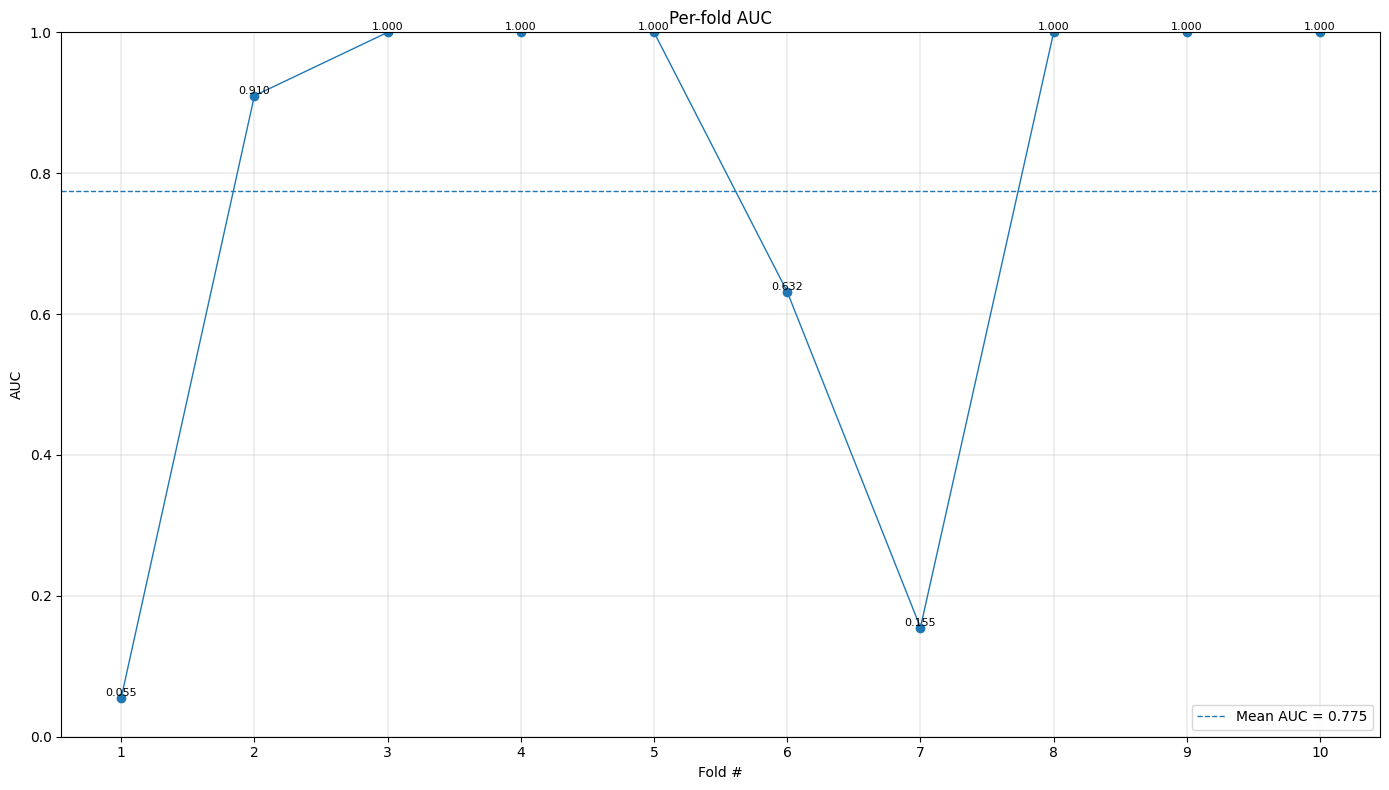

In [9]:
# === Plot per-fold AUCs ===
import matplotlib.pyplot as plt
import numpy as np

fold_indices = np.arange(1, len(fold_aucs) + 1, dtype=int)
auc_array = np.array(fold_aucs, dtype=float)

plt.figure(figsize=(14, 8))
# line+markers; NaNs will break the line, which is fine
plt.plot(fold_indices, auc_array, marker="o", linewidth=1)

# annotate non-NaN points with their values
for i, a in enumerate(auc_array, start=1):
    if not np.isnan(a):
        plt.text(i, a, f"{a:.3f}", ha="center", va="bottom", fontsize=8)

# draw mean AUC if available
valid_mask = ~np.isnan(auc_array)
if valid_mask.any():
    mean_auc = auc_array[valid_mask].mean()
    plt.axhline(mean_auc, linestyle="--", linewidth=1, label=f"Mean AUC = {mean_auc:.3f}")

plt.title("Per-fold AUC")
plt.xlabel("Fold #")
plt.ylabel("AUC")
plt.xticks(fold_indices)
plt.ylim(0.0, 1.0)
plt.grid(True, linewidth=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()